## Imports

In [18]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

## Load data from Excel file

In [19]:
def load_data(file_path, sheet_name='Road Information.shp'):
    return pd.read_excel(file_path, sheet_name=sheet_name)

## Preprocess the data, fill NaN values

In [20]:
def preprocess_data(data):
    data.fillna(0, inplace=True)
    data['Length'] = data['Length'].astype(float)
    data['AADT'] = data['AADT'].astype(int)
    data['Speed_Lmt'] = data['Speed_Lmt'].astype(int)
    data['SNW_ACC_D'] = data['SNW_ACC_D'].astype(float)
    data['SNW_ACC_T'] = data['SNW_ACC_T'].astype(float)
    data['ICE_TIME'] = data['ICE_TIME'].astype(float)
    data['NumLanes'] = data['NumLanes'].astype(int)
    data['LaneKM'] = data['LaneKM'].astype(float)
    return data

## Extract frequency and interval

In [21]:
def extract_frequency_days(freq_str):
    if pd.isna(freq_str):
        return (np.nan, np.nan)
    try:
        tokens = freq_str.split()
        if "Once" in tokens:
            interval = int(tokens[-2])
            return (1, interval)
        elif "times" in tokens:
            frequency = int(tokens[0])
            interval = int(tokens[-2])
            return (frequency, interval)
        else:
            return (np.nan, np.nan)
    except (ValueError, IndexError):
        return (np.nan, np.nan)

## Prepare features

In [22]:
def prepare_features(data, selected_features, categorical_features):
    encoder = OneHotEncoder()
    encoded_categorical = encoder.fit_transform(data[categorical_features]).toarray()
    features = np.hstack((data[selected_features].values, encoded_categorical))
    return features, encoder, data[categorical_features]

## Prepare target variables for frequency and interval

In [23]:
def prepare_targets(data):
    target_frequency = data.apply(lambda x: x[0])
    target_interval = data.apply(lambda x: x[1])
    return target_frequency, target_interval

## Train and evaluate the linear regression models for frequency and interval

In [24]:
def train_evaluate_model(X_train, y_train_freq, y_train_interval, X_test, y_test_freq, y_test_interval, model_freq=None, model_interval=None):
    # Train the frequency model
    if model_freq is None:
        model_freq = LinearRegression()
    model_freq.fit(X_train, y_train_freq)
    y_pred_freq = model_freq.predict(X_test)
    
    # Train the interval model
    if model_interval is None:
        model_interval = LinearRegression()
    model_interval.fit(X_train, y_train_interval)
    y_pred_interval = model_interval.predict(X_test)
    
    # Ensure predictions are at least 1
    y_pred_freq = np.maximum(y_pred_freq, 1)
    y_pred_interval = np.maximum(y_pred_interval, 1)
    
    # Combine frequency and interval predictions
    y_pred = np.column_stack((y_pred_freq, y_pred_interval))
    
    # Calculate evaluation metrics
    metrics = {
        'MAE': mean_absolute_error(np.column_stack((y_test_freq, y_test_interval)), y_pred),
        'MSE': mean_squared_error(np.column_stack((y_test_freq, y_test_interval)), y_pred),
        'R2': r2_score(np.column_stack((y_test_freq, y_test_interval)), y_pred)
    }

    return (model_freq, model_interval), y_pred, metrics

## Decode the predictions 

In [25]:
def decode_prediction(y_pred, street_names, street_intersections):
    decoded = []
    seen = set() 
    for i, (freq, interval) in enumerate(y_pred):
        freq = round(freq)
        interval = round(interval)
        st_name = street_names.iloc[i]
        st_int = street_intersections.iloc[i]
        
        if "/" in st_name:
            continue  
        
        if freq == 1:
            if interval != 1:
                prediction = f"{st_name} - {st_int}: Once every {interval} days"
            else:
                prediction = f"{st_name} - {st_int}: Once daily"
        elif interval == 1:
            if freq == 1:
                prediction = f"{st_name} - {st_int}: Once daily"
            else:
                prediction = f"{st_name} - {st_int}: {freq} times daily"
        elif freq > 1:
            if interval == 1:
                prediction = f"{st_name} - {st_int}: {freq} times daily"
        else:
            prediction = f"{st_name} - {st_int}: {freq} times every {interval} days"
        
        if prediction not in seen:
            seen.add(prediction)
            decoded.append(prediction)
    
    return decoded

## Plot the model performance

In [26]:
def plot_model_performance(y_test_freq, y_pred_freq, y_test_interval, y_pred_interval):
    plt.figure(figsize=(12, 5))

    # Plot frequency predictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_freq, y_pred_freq, alpha=0.7)
    plt.plot([min(y_test_freq), max(y_test_freq)], [min(y_test_freq), max(y_test_freq)], color='red', linewidth=2)
    plt.xlabel('Actual Frequency')
    plt.ylabel('Predicted Frequency')
    plt.title('Actual vs Predicted Patrol Frequency')

    # Plot interval predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_interval, y_pred_interval, alpha=0.7)
    plt.plot([min(y_test_interval), max(y_test_interval)], [min(y_test_interval), max(y_test_interval)], color='red', linewidth=2)
    plt.xlabel('Actual Interval')
    plt.ylabel('Predicted Interval')
    plt.title('Actual vs Predicted Patrol Interval')

    plt.tight_layout()
    plt.show()

## Execute the Model

## Define file paths directly

In [27]:
base_dir = os.getcwd() 
dataset_dir = os.path.join(base_dir, 'dataset')
road_segments_file = os.path.join(dataset_dir, 'road_information.xlsx')
model_dir = os.path.join(base_dir, 'models')
os.makedirs(model_dir, exist_ok=True)
model_freq_path = os.path.join(model_dir, 'model_freq.joblib')
model_interval_path = os.path.join(model_dir, 'model_interval.joblib')
encoder_path = os.path.join(model_dir, 'encoder.joblib')

In [34]:
if __name__ == "__main__":
    # Load and preprocess data
    data = load_data(road_segments_file)
            
    print("Initial Data Preview:")
    print(data.head())

Initial Data Preview:
   FID  Id       ST_NAME                    ST_INT  Length  AADT  Speed_Lmt  \
0    0   0    Powley St.       Dunedin to Dufferin     132   300         50   
1    1   0   Dunedin St.        Victoria to Powley     191   800         50   
2    2   0   Dunedin St.           Powley to Elmer     163   800         50   
3    3   0   Dunedin St.  Elmer Park to Barrie Rd.     142   800         50   
4    4   0  Dufferin St.    Powley St to Barrie Rd     227   500         50   

   Class  SNW_ACC_D  SNW_ACC_T           PTRL_FREQ  ICE_TIME Assumed  \
0      5         10         24  Once every 14 days        16           
1      4          8         16  Once every 14 days        12           
2      4          8         16  Once every 14 days        12           
3      4          8         16  Once every 14 days        12           
4      4          8         16  Once every 14 days        12           

   NumLanes  LaneKM Area  Routes_11  
0         2     264             

In [35]:
    data = preprocess_data(data)
    
    print("Data Information After Preprocessing:")
    print(data.info())

Data Information After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FID        952 non-null    int64  
 1   Id         952 non-null    int64  
 2   ST_NAME    952 non-null    object 
 3   ST_INT     952 non-null    object 
 4   Length     952 non-null    float64
 5   AADT       952 non-null    int32  
 6   Speed_Lmt  952 non-null    int32  
 7   Class      952 non-null    int64  
 8   SNW_ACC_D  952 non-null    float64
 9   SNW_ACC_T  952 non-null    float64
 10  PTRL_FREQ  952 non-null    object 
 11  ICE_TIME   952 non-null    float64
 12  Assumed    952 non-null    object 
 13  NumLanes   952 non-null    int32  
 14  LaneKM     952 non-null    float64
 15  Area       952 non-null    object 
 16  Routes_11  952 non-null    int64  
dtypes: float64(5), int32(3), int64(4), object(5)
memory usage: 115.4+ KB
None


In [36]:
    # Extract patrol frequencies
    data['PTRL_FREQ'] = data['PTRL_FREQ'].apply(extract_frequency_days)
    data.dropna(subset=['PTRL_FREQ'], inplace=True)
    
    print("Extracted Patrol Frequencies:")
    print(data['PTRL_FREQ'].head())

Extracted Patrol Frequencies:
0    (1, 14)
1    (1, 14)
2    (1, 14)
3    (1, 14)
4    (1, 14)
Name: PTRL_FREQ, dtype: object


In [37]:
    # Prepare target variables
    data['target_frequency'], data['target_interval'] = prepare_targets(data['PTRL_FREQ'])
    selected_features = ['Length', 'AADT', 'Speed_Lmt', 'SNW_ACC_T', 'ICE_TIME', 'NumLanes', 'LaneKM']
    categorical_features = ['ST_NAME', 'ST_INT']

    # Prepare features and targets
    X, encoder, original_categorical = prepare_features(data, selected_features, categorical_features)
    y_freq, y_interval = prepare_targets(data['PTRL_FREQ'])

    # Filter out rows with NaN values in target variables
    mask = ~y_freq.isna() & ~y_interval.isna()
    X = X[mask]
    y_freq = y_freq[mask]
    y_interval = y_interval[mask]

    if y_freq.isnull().values.any() or y_interval.isnull().values.any():
        raise ValueError("Target variables contain NaN values. Please handle missing values.")
    else:
        print('No NaN Values')

No NaN Values


In [38]:
    # Split data into training and testing sets
    X_train, X_test, y_train_freq, y_test_freq = train_test_split(X, y_freq, test_size=0.2, random_state=42)
    X_train, X_test, y_train_interval, y_test_interval = train_test_split(X, y_interval, test_size=0.2, random_state=42)

    # Load existing models if available, otherwise create new models
    if os.path.exists(model_freq_path) and os.path.exists(model_interval_path) and os.path.exists(encoder_path):
        model_freq = joblib.load(model_freq_path)
        model_interval = joblib.load(model_interval_path)
        encoder = joblib.load(encoder_path)
        print("Models and encoder loaded from disk.")
    else:
        model_freq = None
        model_interval = None
        print("No existing models found. New models will be created.")
        # Train and evaluate the models
        models, y_pred, metrics = train_evaluate_model(X_train, y_train_freq, y_train_interval, X_test, y_test_freq, y_test_interval, model_freq, model_interval)

        # Save the models and encoder to disk
        joblib.dump(models[0], model_freq_path)
        joblib.dump(models[1], model_interval_path)
        joblib.dump(encoder, encoder_path)
        print("Models and encoder saved to disk.")

Models and encoder loaded from disk.


In [40]:
        # Decode and print predictions
        decoded_predictions = decode_prediction(y_pred, original_categorical['ST_NAME'], original_categorical['ST_INT'])

        print(f"Mean Absolute Error: {metrics['MAE']:.2f}")
        print(f"Mean Squared Error: {metrics['MSE']:.2f}")
        print(f"R-squared: {metrics['R2']:.2f}")

Mean Absolute Error: 0.23
Mean Squared Error: 0.67
R-squared: 0.85


In [41]:
        print("Decoded Predictions:")
        for pred in decoded_predictions:
            print(pred)

Decoded Predictions:
Powley St. - Dunedin to Dufferin: Once every 30 days
Dunedin St. - Victoria to Powley: Once every 30 days
Dunedin St. - Powley to Elmer: Once every 7 days
Dunedin St. - Elmer Park to Barrie Rd.: Once every 16 days
Dufferin St. - Victoria St to Powley St: Once every 14 days
Victoria St. - Dunedin St to Dufferin St: Once every 30 days
Barrie Rd. - Dunedin St to Dufferrin St: Once every 14 days
Dunedin St. - Memorial Ave to Victoria St: Once every 30 days
Dufferin St - Colborne St to Victoria St: Once every 14 days
Dunlop St - Colborne St to Victoria St: Once every 14 days
Victoria St. - Dufferin St to Dunlop St: Once every 14 days
Dunlop St. - Victoria St to Powley St: Once every 14 days
Powley St - Dufferin St to Dunlop St: Once every 30 days
Dunlop St - Powley St to Barrie Rd: Once every 7 days
Victoria St - Dunlop St to Wyandotte St: Once every 30 days
Wyandotte St. - Colborne St to Victoria St: Once every 14 days
Wyandotte St. - Victoria St to Powley St: Once eve

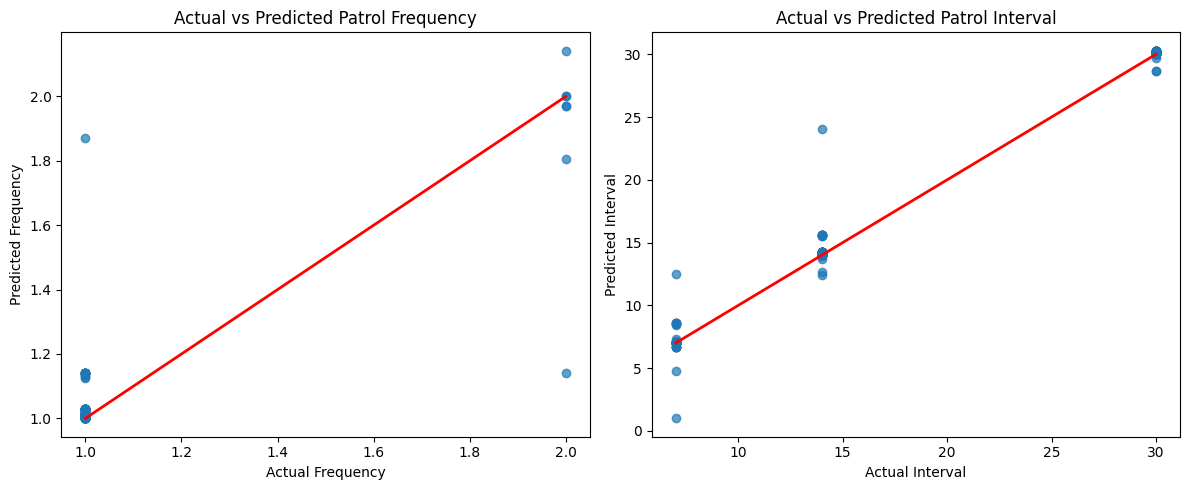

In [42]:
        # Plot the model performance
        plot_model_performance(y_test_freq, y_pred[:, 0], y_test_interval, y_pred[:, 1])